# Adversarial Sample Generation
Fast Gradient Sign Attack (FGSM)

## Threat the model

attacker's knowledge
- white box : having access to the model(architectures), inputs, outputs, weights (FGSM)
- black box : having access to inputs and outputs

<br/>

goals
- misclassification
- source / target misclassification
    - misclassification with target class



## Fast Gradient Sign Attack
the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

![FGSM_panda](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)

## Implementation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Inputs
- `epsilons` - List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is
[0,1], no epsilon value should exceed 1.

- `pretrained_model` - path to the pretrained MNIST model which was trained with pytorch/examples/mnist. For simplicity, download the pretrained model here.

- `use_cuda` - boolean flag to use CUDA if desired and available. Note, a GPU with CUDA is not critical for this tutorial as a CPU will not take much time

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda = True
torch.manual_seed(42)

## Model Under Attack

In [5]:
# LeNet (restyled, CANNOT LOAD pretrained model .pth in tutorial)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                             kernel_size=3, stride=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=364,
                                             kernel_size=3, stride=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

        self.MLP = nn.Sequential(nn.Flatten(),
                                 nn.Linear(in_features=9216, out_features=128),
                                 nn.ReLU())

        self.classifier = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        x = self.convs(x)
        x = self.dropout1(x)
        x = self.MLP(x)
        x = self.dropout2(x)
        x = self.classifier(x)
        output = nn.LogSoftmax(x, dim=1)
        return output


In [6]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [7]:
# transforms
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# dataset, dataloader
MNIST_dataset = datasets.MNIST('../data',
                               train=False,
                               download=True,
                               transform=data_transforms)

test_dataloader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                              batch_size=1,
                                              shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110603704.31it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18398495.42it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28677367.90it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23519171.32it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [8]:
# agnostic
# !nvidia-smi
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# load model
model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location=device))

model.eval()    # set model in evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## FGSM Attatck

$$
    I_{\text{preturbed}} = x + ɛ \cdot \text{sign}(\nabla_x J(\theta, x, y))
$$

In [10]:
def fgsm_attatck(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()    # signed grad data
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


with regard to `torch.clamp()`
```python
>>> a = torch.randn(4)
>>> a
tensor([-1.7120,  0.1734, -0.0478, -0.0922])
>>> torch.clamp(a, min=-0.5, max=0.5)
tensor([-0.5000,  0.1734, -0.0478, -0.0922])
```

In [11]:
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale. (detransform)

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

## Testing function

In [25]:
def test(model, device, test_loader, epsilon):
    """test fgsm attack (within training loop)"""

    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # normal prediction
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():    # init_pred : correct classification
            continue

        # backprop
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()

        # perturbed prediction
        data_grad = data.grad.data
        data_denorm = denorm(data)

        perturbed_data = fgsm_attatck(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = model(perturbed_data_normalized)
        final_pred = output.max(1, keepdim=True)[1]    # final_pred : attacked classification

        if final_pred.item() == target.item():
            correct += 1

            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        elif len(adv_examples) < 5:
            # Save some adv examples for visualization later
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    return final_acc, adv_examples


## Run attack

In [26]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.15	Test Accuracy = 7111 / 10000 = 0.7111
Epsilon: 0.2	Test Accuracy = 4877 / 10000 = 0.4877
Epsilon: 0.25	Test Accuracy = 2717 / 10000 = 0.2717
Epsilon: 0.3	Test Accuracy = 1418 / 10000 = 0.1418


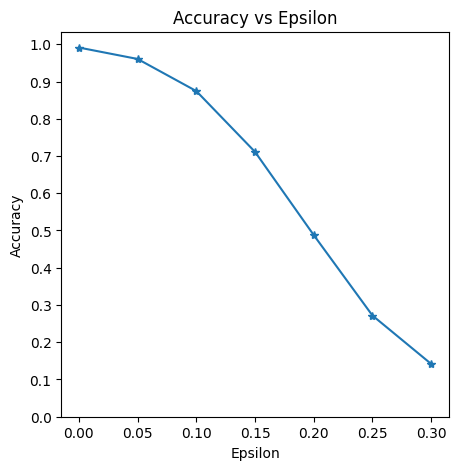

In [29]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample Adversarial Examples

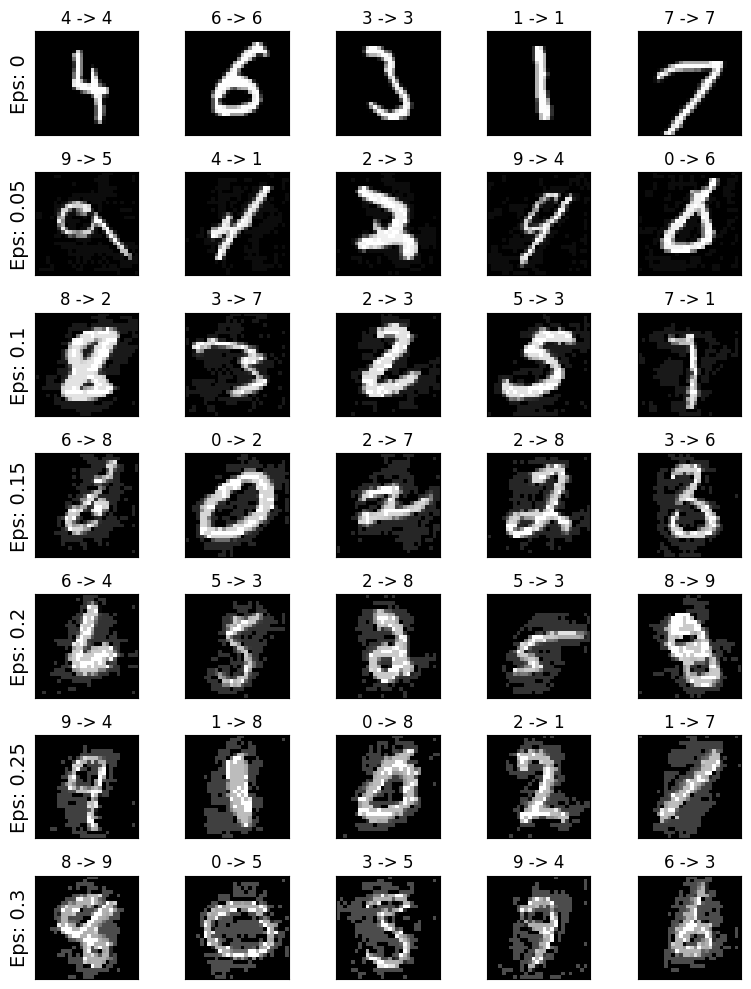

In [28]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()